# Time Series (Use case II) Replication



##### Sebastián Contreras del Moral

### Import de las librerias utilizadas

In [1]:

import warnings
import itertools
import numpy as np
import pandas as pd
from datetime import date

# matplotlib
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
plt.style.use('fivethirtyeight')

# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#scikit learn
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

### Configuración plot

In [2]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Explicación dataset
El dataset ha sido cogido de: https://www.kaggle.com/sogun3/uspollution?select=pollution_us_2000_2016.csv.
Este dataset cuenta con 29 columnas que recogen datos por día desde el 2000 hasta el 2016 de la contaminación en los estados de EEUU, recogen varios tipos de contaminación, nosotros analizaremos la columa de "NO2 AQI", el NO2 es un compuesto químico gaseoso(dióxido de nitrógeno) junto al NOx son los principales contaminantes de las ciudades. Nuestra idea es predecir como será el próximo año.

### Cargar dataset

In [3]:
df = pd.read_csv("D:\\uspollution_pollution_us_2000_2016.csv", delimiter = ",",error_bad_lines=False)
df.head()

,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


### Preparación de los datos para el posterior análisis y predicción

In [4]:
# Creamos un nuevo dataframe seleccionando unicamente los estados de Louisiana
louisiana = df.loc[df['State'] == 'Louisiana']

In [5]:
# Rango de nuestros datos
louisiana['Date Local'].min(), louisiana['Date Local'].max()

('2000-01-01', '2016-04-27')

In [6]:
# Número de observaciones
louisiana.count()

Unnamed: 0           23874
State Code           23874
County Code          23874
Site Num             23874
Address              23874
State                23874
County               23874
City                 23874
Date Local           23874
NO2 Units            23874
NO2 Mean             23874
NO2 1st Max Value    23874
NO2 1st Max Hour     23874
NO2 AQI              23874
O3 Units             23874
O3 Mean              23874
O3 1st Max Value     23874
O3 1st Max Hour      23874
O3 AQI               23874
SO2 Units            23874
SO2 Mean             23874
SO2 1st Max Value    23874
SO2 1st Max Hour     23874
SO2 AQI              11938
CO Units             23874
CO Mean              23874
CO 1st Max Value     23874
CO 1st Max Hour      23874
CO AQI               11937
dtype: int64

In [7]:
# Nos centraremos en la columna NO2 AQI, por lo que el resto las eliminaremos para agilizar el trabajo.
louisiana.columns
# Guardamos las columnas en una lista.
columnas = ['Unnamed: 0', 'State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'City', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour',  'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI']

# Eliminamos todas las que no nos serán utiles.
louisiana.drop(columnas, axis=1, inplace=True)

In [8]:
# Ordenamos por fecha.
louisiana = louisiana.sort_values('Date Local')
# Comprobamos null.
louisiana.isnull().sum()

Date Local    0
NO2 AQI       0
dtype: int64

In [9]:
# Agregaremos los datos que han sido tomados el mismo día, hay varios registros ya que nosotros estamos realizando el análisis
# por estado, pero los datos han sido tomados por ciudad. Lo recomendable no seria agrupar y ver como evoluciona por ciudad pero 
# se haría demasiado extenso. Al agrupar debemos resetear el índice y que se ajuste de nuevo.
louisiana = louisiana.groupby('Date Local')['NO2 AQI'].sum().reset_index()

In [10]:
# Convertir las fechas a datetime.
louisiana['Date Local'] = pd.to_datetime(louisiana['Date Local'])

In [11]:
# Indexar los datos
louisiana = louisiana.set_index('Date Local')
louisiana.index
louisiana.head()

,NO2 AQI
Date Local,
2000-01-01,280
2000-01-02,104
2000-01-03,72
2000-01-04,120
2000-01-05,168


In [12]:
# Como el dataset es muy extenso y para facilitar la visualización  y agilizar el análisis, nos quedaremos con este tramo.
louisiana = louisiana.loc['2010-01-01':'2016-01-01']

In [13]:
# Espaciar las fechas por incio de mes.
y = louisiana['NO2 AQI'].resample('MS').mean()
y['2015':]

Date Local
2015-01-01    90.451613
2015-02-01    93.714286
2015-03-01    82.967742
2015-04-01    80.533333
2015-05-01    62.709677
2015-06-01    62.133333
2015-07-01    57.548387
2015-08-01    71.379310
2015-09-01    68.933333
2015-10-01    82.064516
2015-11-01    65.733333
2015-12-01    72.903226
2016-01-01    52.000000
Freq: MS, Name: NO2 AQI, dtype: float64

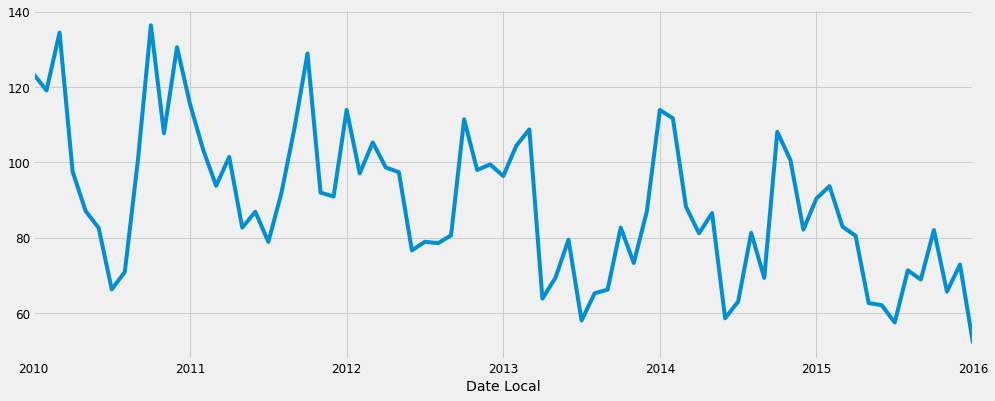

In [14]:
# Primera visualización
y.plot(figsize=(15,6))
plt.show()

Podemos observar que la tendencia de la contaminación es descendente, aunque con picos elevados a finales y principio de año mientras que en el acuador del año parece descender, aunque no podemos sacar nada claro en una primera vista. La disminución es algo que tiene sentido ya que las medidas contra la contaminación cada vez son mas estrictas.

### Descomponemos la serie

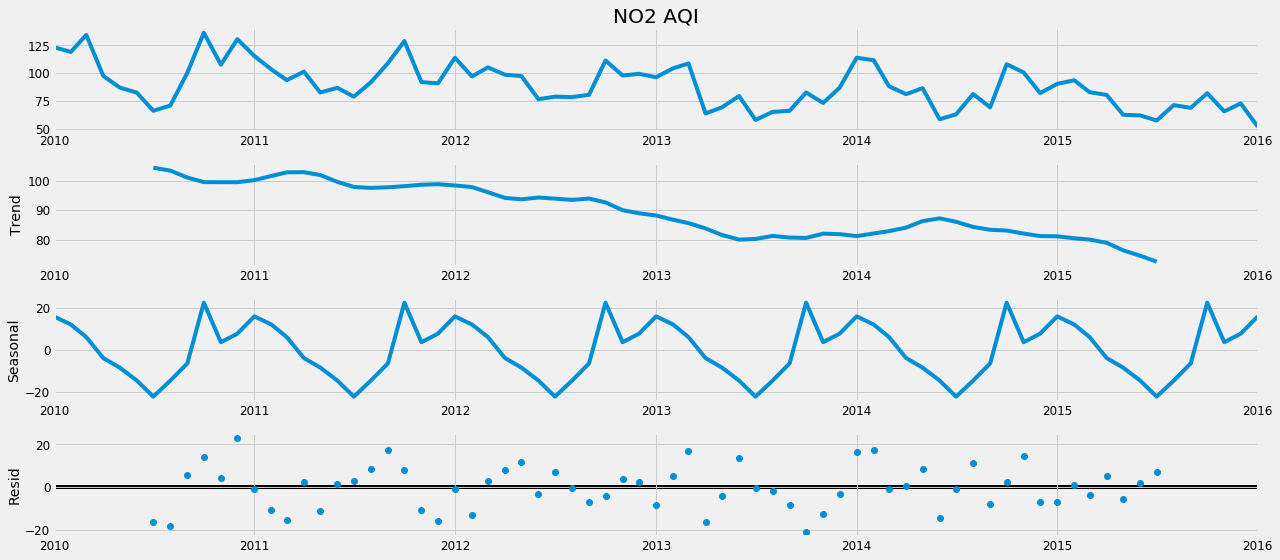

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Tras realizar la descompisión de la serie, podemos observar en la componente de tendecia como hemos dicho anteriormente que sigue un patrón descendente a medida que pasan los años. Respecto a la componente estacional vemos que la estacionalidad es bastante fuerte a finales de año, parece ser una fecha destacada que habria que investigar para encontrar el motivo. Los residuos parecen ajustarse a un ruido blanco, aunque deberiamos estudiarlo mejor porque hay puntos que se escapan.

### Comprobamos estacionaridad con Dickey-Fuller

In [16]:
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=12,center=True).mean()
    rolstd = timeseries.rolling(window=12,center=True).std()
    # rolling statistics plot
    pyplot.figure(figsize=(40,10))
    orig = plt.plot(timeseries, color='blue',label='Time Series')
    mean = plt.plot(rolmean, color='red', label='Mean rolling')
    std = plt.plot(rolstd, color='black', label = 'Std. rolling')
    plt.legend(loc='best')
    plt.title('Time series with rolling mean and std')
    plt.show(block=False)
    # Dicket-Fuller test
    dftest = adfuller(timeseries.values, autolag='AIC')
    tstat = dftest[0]; pvalue = dftest[1]; cvalues = dftest[4]
    print('Dickey-Fuller Results')
    print("------------------")
    print("Test statistic\t",tstat)
    print("p-value\t\t\t",pvalue)
    print("------------------")
    print("Critical values (The test statistic should be lower)")
    for clevel in [10,5,1]:
        conf = 100-clevel
        cval = cvalues['%i%%' % clevel]
        if tstat < cval:
            comp = ">"
            verdict = "Pass"
        else:
            comp = "<"
            verdict = "Fails"
        print("Confidence %i%%\t\t%f %s %f ... %s" % (conf, cval, comp, tstat, verdict))

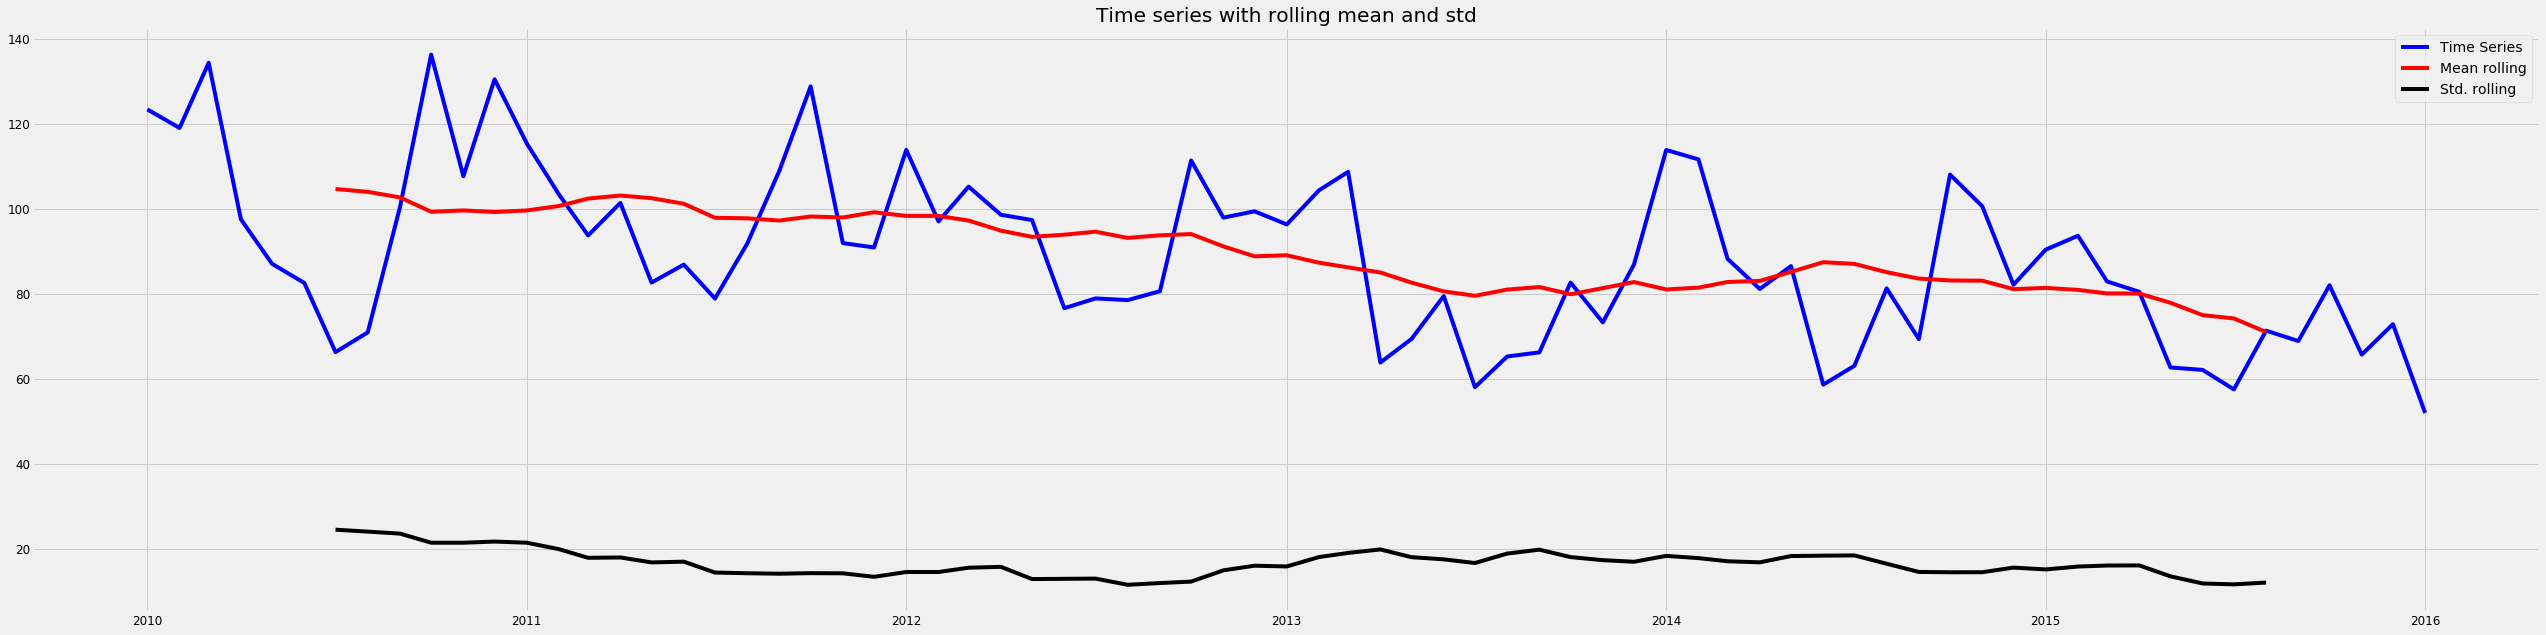

Dickey-Fuller Results
------------------
Test statistic	 -4.011760088562151
p-value			 0.0013501685214103636
------------------
Critical values (The test statistic should be lower)
Confidence 90%		-2.588679 > -4.011760 ... Pass
Confidence 95%		-2.902607 > -4.011760 ... Pass
Confidence 99%		-3.524624 > -4.011760 ... Pass


In [17]:
test_stationarity(y)

Analizaremos tres partes:
* Gráfica: podemos observar como la media y la varianza son más o menos estables, por lo que podemos pensar que la serie es estacionaria.
* Resultado test y p-valor: fijandonos en el resultado del test estadístico que hemos obtenido vemos que ha sido un resultado bueno(más negativo mejor resultado)y por otro lado el resultado del p-valor cuanto más proximo a 0 mejor.
* Intervalos de confianza: se calculan los resultados con varios valores de confianza y en los distintos valores ha pasado el test.

Como conclusión tenemos que la serie es estacionaria o se puede estacionariar.

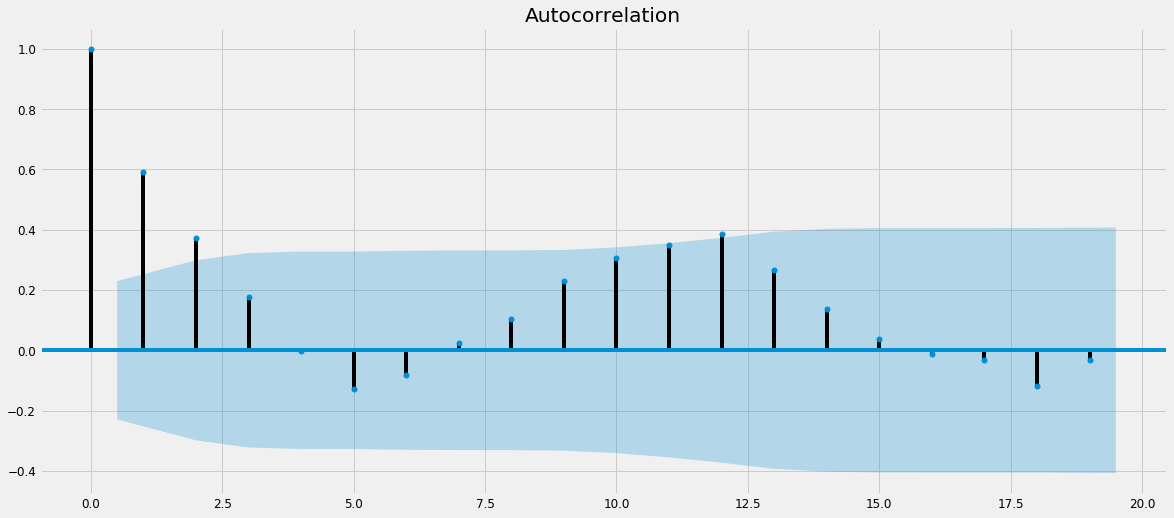

In [18]:
# Función de autocorrelación
plot_acf(y)
pyplot.show()

Algunos retardos salen de la franja, suele ocurrir al ser datos reales, por lo general parecen seguir una forma sinusoidal(ruido blanco) los valores no parecen depender de los siguientes.

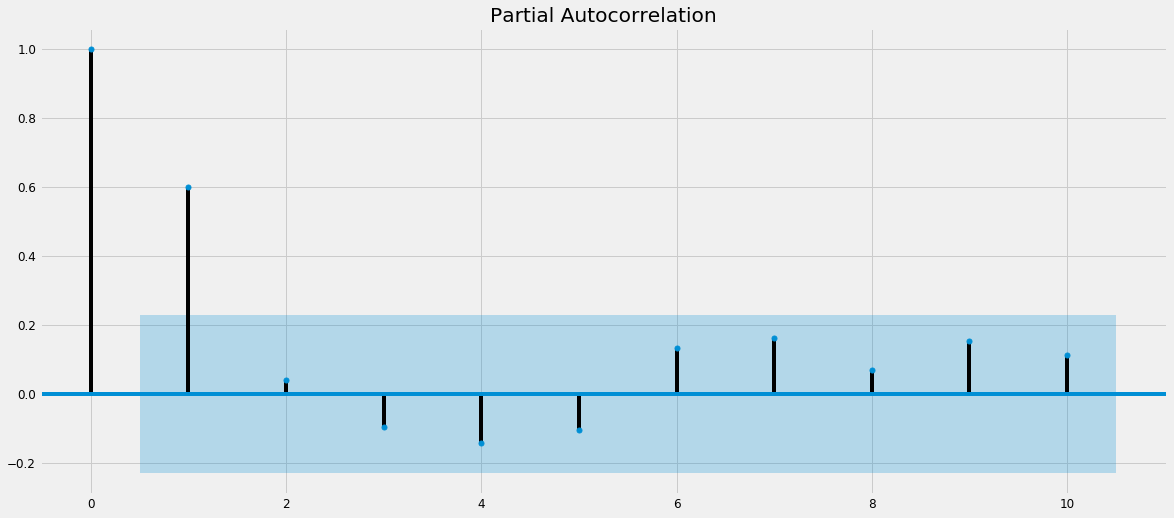

In [19]:
# Función de autocorrelación parcial
plot_pacf(y, lags=10)
pyplot.show()


### Series temporales con ARIMA

In [20]:
# Parámetros:
# p--> la parte autoregresiva de la variables de interés
# q--> la parte de medias móviles
# d--> orden de diferenciación regular
# P,Q,D para la parte estacional
p = q = range(0, 3) 
d = range(0, 1) 
P = Q = range(0, 3) 
D = range(0, 1)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
warnings.filterwarnings("ignore")

min_aic = 2000

In [21]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                parameter = param
                parameter_seasonal = param_seasonal
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:855.6286955387113
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:660.2677026864526
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:515.4758934230067
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:485.8670944726286
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:399.0187967082924
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:395.4016862272885
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:767.2181994671867
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:591.315104002247
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:2090.9768799043304
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:518.2027296641055
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:475.2893153990122
ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:383.75336329493626
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:396.1473717197978
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:393.2347061678314
ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:379.7991463817246
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:708.8943316185

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
error1 = mean_squared_error(y,pred.predicted_mean)
print('\n --- MIN AIC ARIMA{}x{}12 - AIC:{} - ECM:{}'.format(parameter, parameter_seasonal, min_aic,error1))


 --- MIN AIC ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:374.44354868672775 - ECM:550.086152359898


In [23]:
# Ajuste del modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(y,
                                order=parameter,
                                seasonal_order=parameter_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])
print(results.summary().tables[2])

                                     SARIMAX Results                                      
Dep. Variable:                            NO2 AQI   No. Observations:                   73
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                -179.222
Date:                            Wed, 15 Jul 2020   AIC                            374.444
Time:                                    22:22:26   BIC                            389.073
Sample:                                01-01-2010   HQIC                           379.924
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2734      0.617      0.443      0.658      -0.936       1.483
ma.L1         -1.3167      2.305   

Analizando los resultados obtenidos en la columna P>|z| vemos la importancia que tiene cada característica, por ejemplo en nuestro caso ar.S.L12(la parte autoregresiva) es la mas significativa porque se acerca a un p-valor de 0,05 pero por lo general no se han obtenido buenos resultados.

### Diagnosis del modelo

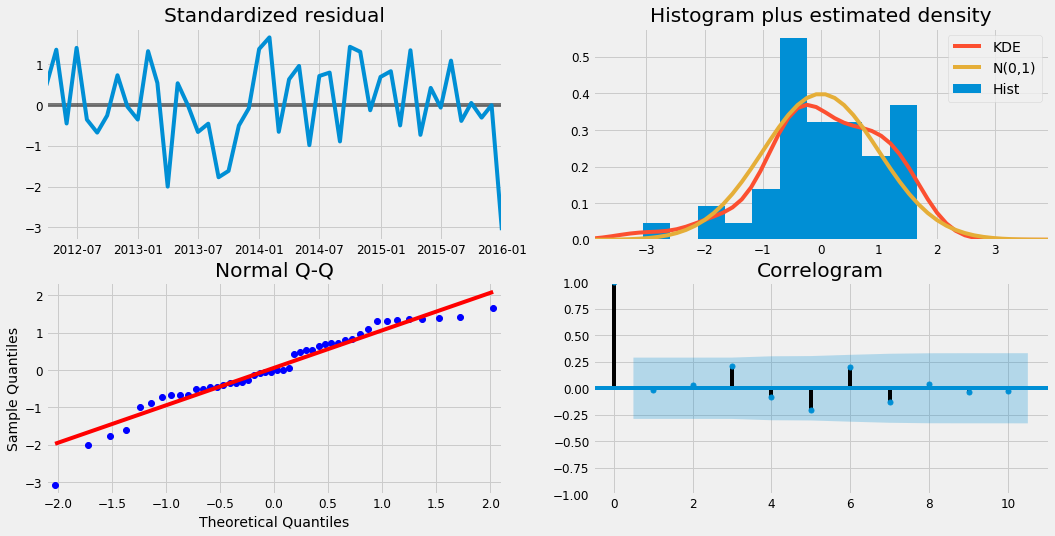

In [24]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Análisis del diagnóstico
* Residuos estandarizados: una gráfica correcta debe seguir ruido blanco es decir picos de subidos y bajada que su media sea 0. En nuestro caso sigue esa condición con algunas excepciones, que parece que hay dispersión.
* El histograma se ajusta a una normal(0-1) aunque no perfectamente, hay zonas donde no se ajusta correctamente lo que era de esperar viendo la dispersión que hemos visto en los residuos.
* Gráfico normal Q-Q: los puntos se ajustan a la línea bastante bien, exceptuando al principio y final.
* Correlograma: El primer valor es uno y el resto bajar hasta ser 0, quiere decir que el modelo esta captando la estacionariedad de la serie correctamente. Los residuos no dependen de los valores anteriores.

### ARIMA, parámetros modificados

In [25]:
# Parámetros:
# p--> la parte autoregresiva de la variables de interés
# q--> la parte de medias móviles
# d--> orden de diferenciación regular
# P,Q,D para la parte estacional
p = q = range(0, 3) 
d = range(0, 1) 
P = Q = range(0, 4) # Modificamos la parte estacional
D = range(0, 1)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
warnings.filterwarnings("ignore")

min_aic = 10000

In [26]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                parameter = param
                parameter_seasonal = param_seasonal
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:855.6286955387113
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:660.2677026864526
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(0, 0, 3, 12)12 - AIC:371.85590161837763
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:515.4758934230067
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:485.8670944726286
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 3, 12)12 - AIC:299.912368963059
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:399.0187967082924
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:395.4016862272885
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(2, 0, 3, 12)12 - AIC:298.1254851048589
ARIMA(0, 0, 0)x(3, 0, 0, 12)12 - AIC:300.91515936813084
ARIMA(0, 0, 0)x(3, 0, 1, 12)12 - AIC:301.1081123036892
ARIMA(0, 0, 0)x(3, 0, 2, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(3, 0, 3, 12)12 - AIC:298.06750694659286
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:767.2181994671867
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:591.315104002247
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:2090.9768799043304
ARIMA(0, 

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
error1 = mean_squared_error(y,pred.predicted_mean)
print('\n --- MIN AIC ARIMA{}x{}12 - AIC:{} - ECM:{}'.format(parameter, parameter_seasonal, min_aic,error1))


 --- MIN AIC ARIMA(0, 0, 2)x(2, 0, 3, 12)12 - AIC:277.3686716240569 - ECM:19891.928053152948


In [28]:
# Ajuste del modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(y,
                                order=parameter,
                                seasonal_order=parameter_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[0])
print(results.summary().tables[1])
print(results.summary().tables[2])

                                         SARIMAX Results                                          
Dep. Variable:                                    NO2 AQI   No. Observations:                   73
Model:             SARIMAX(0, 0, 2)x(2, 0, [1, 2, 3], 12)   Log Likelihood                -130.684
Date:                                    Wed, 15 Jul 2020   AIC                            277.369
Time:                                            22:24:33   BIC                            289.580
Sample:                                        01-01-2010   HQIC                           281.533
                                             - 01-01-2016                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3429      0.280      1.224      0

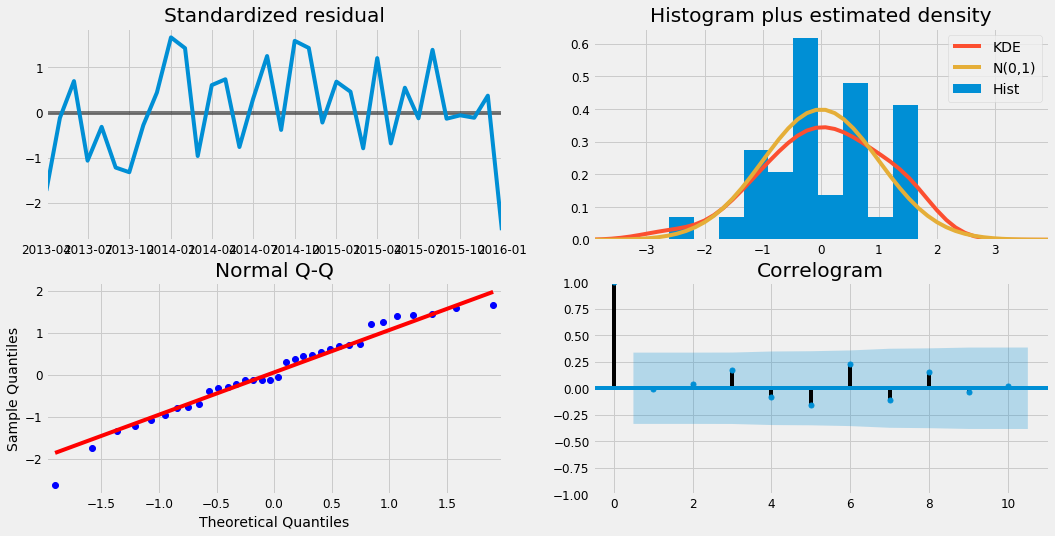

In [29]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Tras muchas modificaciones la única que he comprado que puede mejorar un poco es esta, la que vemos que ajusta mejor el histograma y el gráfico Q-Q se ajusta bien exceptuando un poco de dispersión. Pero debemos tener que son datos reales por lo cual es dificil conseguir que se ajuste a la perfección.

### Validar forecast

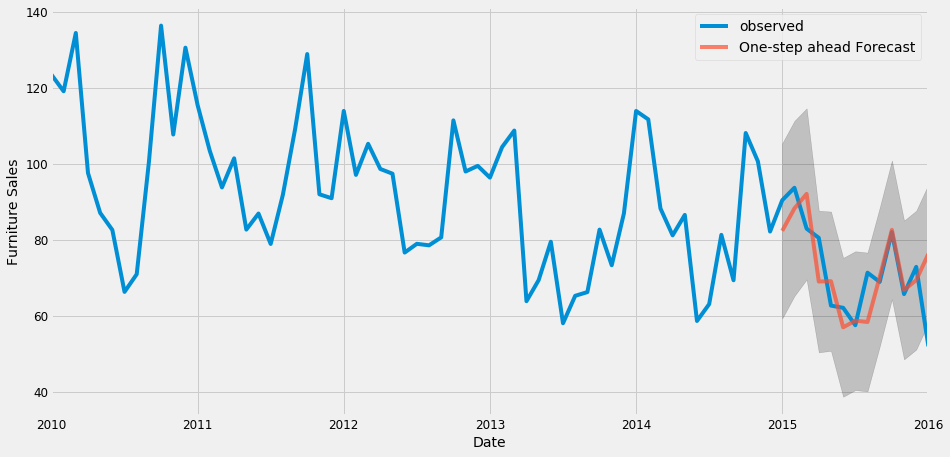

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Parece que la predicción se ajusta bastante bien según podemos observar el resultado obtenido anteriormente.

In [31]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 97.81
The Root Mean Squared Error of our forecasts is 9.89


### Visualización forecast

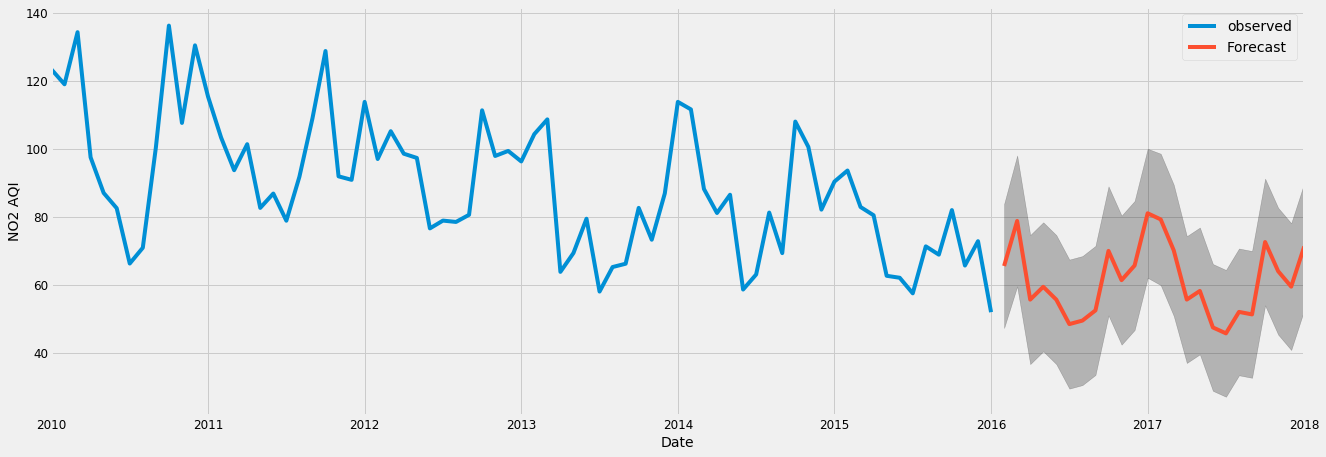

In [32]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('NO2 AQI')
plt.legend()
plt.show()

La predicción está dentro de los límites y parece que sigue los patrones que estamos obteniendo desde el comienzo, a primera vista parece que ha sido una predicción válida.

### Comparación de NO2 AQI de Louisiana vs Oklahoma.

##### Repetimos los primeros paso de preparación pero para Oklahoma

In [33]:
oklahoma = df.loc[df['State'] == 'Oklahoma']

In [34]:
oklahoma.drop(columnas, axis=1, inplace=True)
oklahoma = oklahoma.sort_values('Date Local')
oklahoma = oklahoma.groupby('Date Local')['NO2 AQI'].sum().reset_index()

In [35]:
#Convertir a datetime
oklahoma['Date Local'] = pd.to_datetime(oklahoma['Date Local'])

In [36]:
# Indexar los datos
oklahoma = oklahoma.set_index('Date Local')
oklahoma.index
oklahoma.head()
oklahoma = oklahoma.loc['2010-01-01':'2016-01-01']

In [37]:
y_louissina = louisiana['NO2 AQI'].resample('MS').mean()
y_oklahoma = oklahoma['NO2 AQI'].resample('MS').mean()

In [38]:
oklahoma = pd.DataFrame({'Date Local':y_oklahoma.index, 'NO2 AQI':y_oklahoma.values})
louisiana = pd.DataFrame({'Date Local': y_louissina.index, 'NO2 AQI': y_louissina.values})

In [39]:
union = louisiana.merge(oklahoma, how='inner', on='Date Local')
union.rename(columns={'NO2 AQI_x': 'louisiana_NO2', 'NO2 AQI_y': 'oklahoma_NO2'}, inplace=True)
union.head()

,Date Local,louisiana_NO2,oklahoma_NO2
0,2010-01-01,123.483871,108.516129
1,2010-02-01,119.111111,108.592593
2,2010-03-01,134.451613,88.774194
3,2010-04-01,97.600000,25.714286
4,2010-05-01,87.111111,39.870968


### Visualización

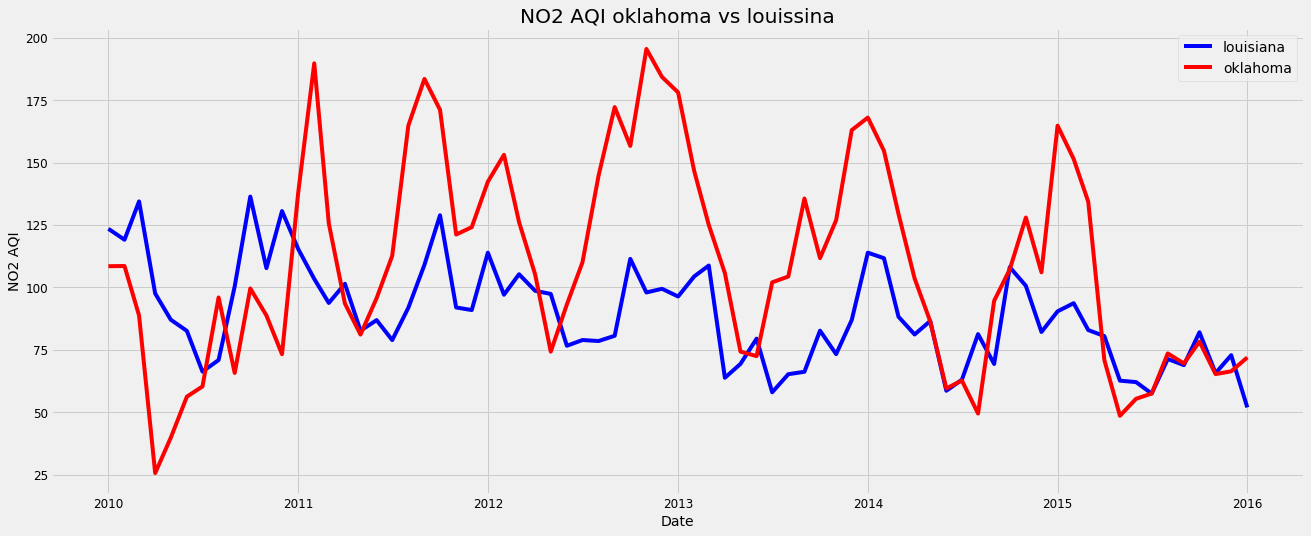

In [40]:
plt.figure(figsize=(20, 8))
plt.plot(union['Date Local'], union['louisiana_NO2'], 'b-', label = 'louisiana')
plt.plot(union['Date Local'], union['oklahoma_NO2'], 'r-', label = 'oklahoma')
plt.xlabel('Date'); 
plt.ylabel('NO2 AQI'); 
plt.title('NO2 AQI oklahoma vs louissina')
plt.legend();

Vemos como Oklahoma tiene un mayor nivel de contaminación, tambien debemos tener en cuenta que hemos agrupado por estado y en este caso los datos están obtenido por ciudad, al relizar las comprobaciones he visto que hay mas datos recogidos, pero aún asi los picos de NO2 AQI son más altos.

In [43]:
first_date = union.loc[np.min(list(np.where(union['oklahoma_NO2'] > union['louisiana_NO2'])[0])), 'Date Local']
print("La contaminación fue mayor en Oklahoma por primera vez {}.".format(first_date.date()))

La contaminación fue mayor en Oklahoma por primera vez 2010-08-01.


### Instalamos Fbprophet

Instalar Fbprophet:
    - conda install -c conda-forge fbprophet

Puede que al instalarlo de problemas con los plot y no los cargue, la solución es hacer:
    - conda install -c plotly plotly 

### Primer ajuste del modelo con Prophet.

In [45]:
from fbprophet import Prophet
louisiana = louisiana.rename(columns={'Date Local': 'ds', 'NO2 AQI': 'y'})
louisiana_model = Prophet(interval_width=0.95)
louisiana_model.fit(louisiana)

oklahoma = oklahoma.rename(columns={'Date Local': 'ds', 'NO2 AQI': 'y'})
oklahoma_model = Prophet(interval_width=0.95)
oklahoma_model.fit(oklahoma)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Previsiones de forecast

In [46]:
louisiana_forecast = louisiana_model.make_future_dataframe(periods=36, freq='MS')
louisiana_forecast = louisiana_model.predict(louisiana_forecast)

oklahoma_forecast = oklahoma_model.make_future_dataframe(periods=36, freq='MS')
oklahoma_forecast = oklahoma_model.predict(oklahoma_forecast)

### Visualización de las predicciones

<Figure size 1296x432 with 0 Axes>

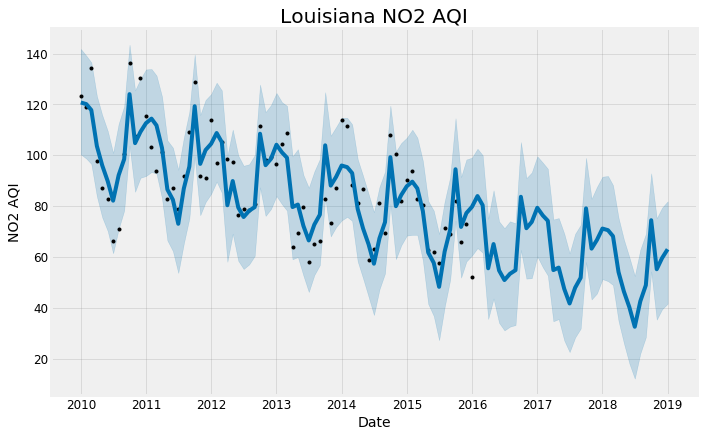

<Figure size 1296x432 with 0 Axes>

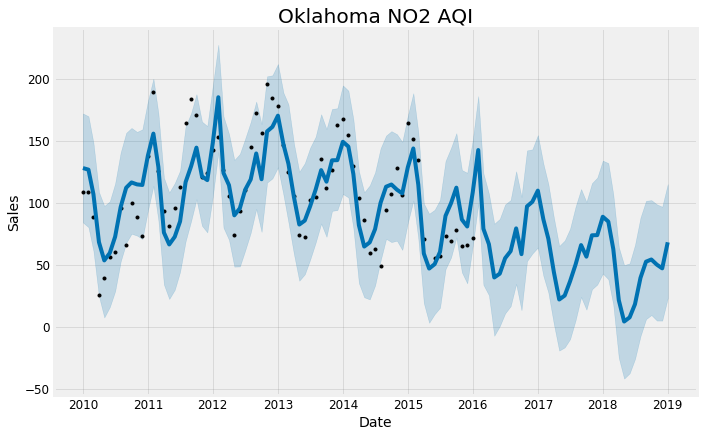

In [47]:
plt.figure(figsize=(18, 6))
louisiana_model.plot(louisiana_forecast, xlabel = 'Date', ylabel = 'NO2 AQI')
plt.title('Louisiana NO2 AQI');

plt.figure(figsize=(18, 6))
oklahoma_model.plot(oklahoma_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Oklahoma NO2 AQI');

La parte con puntos corresponde donde se va generando el modelo de la serie y otro lado los resultados predichos, por lo general parece que se ajusta aproximandamente a los puntos, aunque algunos están un poco alejados.

### Comparar la predicción

In [48]:
louisiana_names = ['louisiana_%s' % column for column in louisiana_forecast.columns]
oklahoma_names = ['oklahoma_%s' % column for column in oklahoma_forecast.columns]

merge_louisiana_forecast = louisiana_forecast.copy()
merge_oklahoma_forecast = oklahoma_forecast.copy()

merge_louisiana_forecast.columns = louisiana_names
merge_oklahoma_forecast.columns = oklahoma_names

forecast = pd.merge(merge_louisiana_forecast, merge_oklahoma_forecast, how = 'inner', left_on = 'louisiana_ds', right_on = 'oklahoma_ds')
forecast = forecast.rename(columns={'louisiana_ds': 'Date'}).drop('oklahoma_ds', axis=1)
forecast.head()

,Date,louisiana_trend,louisiana_yhat_lower,louisiana_yhat_upper,louisiana_trend_lower,louisiana_trend_upper,louisiana_additive_terms,louisiana_additive_terms_lower,louisiana_additive_terms_upper,louisiana_yearly,...,oklahoma_additive_terms,oklahoma_additive_terms_lower,oklahoma_additive_terms_upper,oklahoma_yearly,oklahoma_yearly_lower,oklahoma_yearly_upper,oklahoma_multiplicative_terms,oklahoma_multiplicative_terms_lower,oklahoma_multiplicative_terms_upper,oklahoma_yhat
0,2010-01-01,108.391671,100.368596,141.847218,108.391671,108.391671,12.380959,12.380959,12.380959,12.380959,...,33.751504,33.751504,33.751504,33.751504,33.751504,33.751504,0.0,0.0,0.0,128.115708
1,2010-02-01,107.865411,98.711283,139.158820,107.865411,107.865411,12.276209,12.276209,12.276209,12.276209,...,31.148934,31.148934,31.148934,31.148934,31.148934,31.148934,0.0,0.0,0.0,126.828521
2,2010-03-01,107.390079,96.597752,136.533133,107.390079,107.390079,10.391799,10.391799,10.391799,10.391799,...,10.163426,10.163426,10.163426,10.163426,10.163426,10.163426,0.0,0.0,0.0,107.031102
3,2010-04-01,106.863819,83.883956,123.320009,106.863819,106.863819,-3.194173,-3.194173,-3.194173,-3.194173,...,-29.742188,-29.742188,-29.742188,-29.742188,-29.742188,-29.742188,0.0,0.0,0.0,68.440872
4,2010-05-01,106.354535,75.601992,115.804736,106.354535,106.354535,-10.318259,-10.318259,-10.318259,-10.318259,...,-45.769660,-45.769660,-45.769660,-45.769660,-45.769660,-45.769660,0.0,0.0,0.0,53.686351


### Visualización de tendencia.

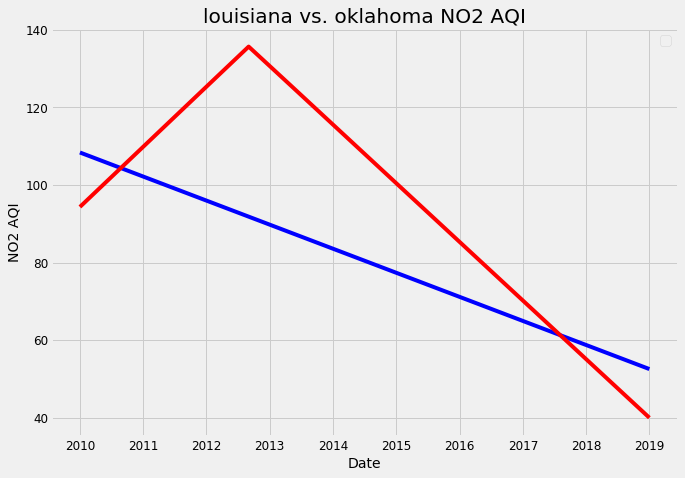

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['louisiana_trend'], 'b-')
plt.plot(forecast['Date'], forecast['oklahoma_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('NO2 AQI')
plt.title('louisiana vs. oklahoma NO2 AQI');

Se ve una clara tendencia descendente en los niveles de contaminación, habría que analizar el pico de subida que corresponde a finales de 2012 a causa de que es debido.

### Visualización forecast

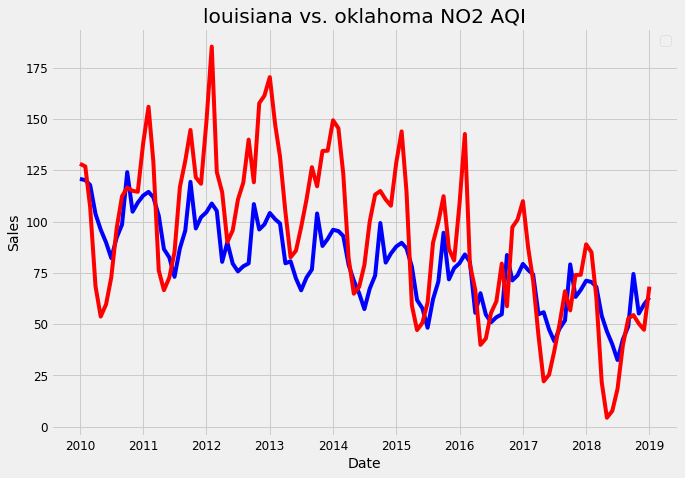

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['louisiana_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['oklahoma_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('louisiana vs. oklahoma NO2 AQI');


### Tendencias y patrones.

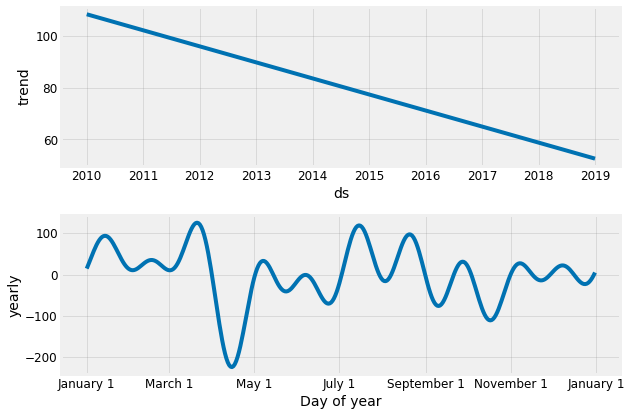

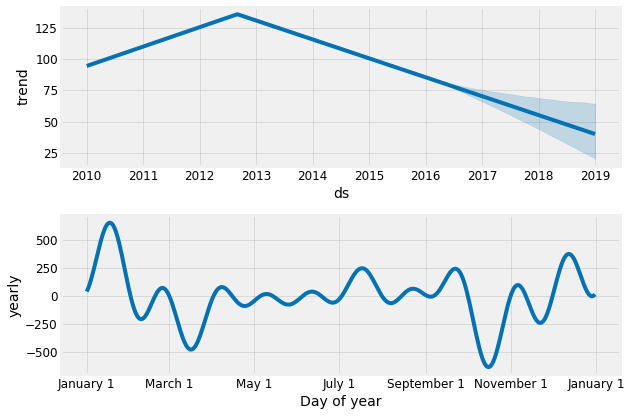

In [53]:
# Descomposición de los componentes con prohphet.
louisiana_model.plot_components(louisiana_forecast);

oklahoma_model.plot_components(oklahoma_forecast);